# Solving Sudokus with ShuffleSoftSort
<p>
This notebook demonstrates gradient-based solving of Sudokus from the paper:
<div style="text-align: center"> 
<H3>"Permutation Learning with Only N Parameters: From SoftSort to Self-Organizing Gaussians"</H3>
<p style='text-align: center;'> Kai Barthel, Florian Tim Barthel, Peter Eisert 
    <br>
 Visual Computing Group HTW Berlin and Fraunhofer HHI</p>
<br>
<p style='text-align: left;'>
Solving Sudokus in an unsupervised environment (without ground truth) or learning from large sets of example problems is a difficult problem. The presented approach works for easy to moderately difficult problems. For very hard Sudokus, solutions may not be found, but the algorithm finds number arrangements with very few violations of the Sudoku rules. </p>

 ## 1. Configuration & Setup

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import List, Tuple, Dict

In [2]:
class Config:
    """Configuration settings for the Sudoku solver."""
    seed: int = 99  # Different seeds will lead to different solving times.
    log_every: int = 100  # How often to log results during solving.
    runs: int = 10000  # Max attempts to solve the puzzle.
    iterations: int = 5  # Min SoftSort iterations per run. 
                         # More iterations improve SoftSort, but risk remaining in local minima.
    learning_rate: float = 0.2  # learning_rate * iterations << 1 will not swap anything.   
    tau: float = 0.5  # Temperature for SoftSort. 0.5 seems to be the best choice here.
    l_std: float = 0.5  # Weight for the standard deviation loss.
    l_constraint: float = 100.0  # Weight for the permutation matrix constraint loss.
    device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    

In [3]:
# A collection of sample puzzles.
SUDOKU_PUZZLES: Dict[str, List[List[int]]] = {
    "easy": [
        [8, 7, 0, 0, 2, 0, 0, 4, 6], [0, 6, 0, 0, 0, 0, 8, 9, 0], [2, 0, 0, 8, 0, 0, 7, 1, 5],
        [0, 8, 4, 0, 9, 7, 0, 0, 0], [7, 1, 0, 0, 0, 0, 0, 5, 9], [0, 0, 0, 1, 3, 0, 4, 8, 0],
        [6, 9, 7, 0, 0, 2, 0, 0, 8], [0, 5, 8, 0, 0, 0, 0, 6, 0], [4, 3, 0, 0, 8, 0, 0, 7, 0]
    ],
    "moderate": [
        [5, 3, 0, 0, 7, 0, 0, 0, 0], [6, 0, 0, 1, 9, 5, 0, 0, 0], [0, 9, 8, 0, 0, 0, 0, 6, 0], 
        [8, 0, 0, 0, 6, 0, 0, 0, 3], [4, 0, 0, 8, 0, 3, 0, 0, 1], [7, 0, 0, 0, 2, 0, 0, 0, 6],
        [0, 6, 0, 0, 0, 0, 2, 8, 0], [0, 0, 0, 4, 1, 9, 0, 0, 5], [0, 0, 0, 0, 8, 0, 0, 7, 9] 
        ],
    "paper1": [ # SUDOQ — A QUANTUM VARIANT OF THE POPULAR GAME   arXiv:2005.10862v1
        [0, 0, 3, 0, 2, 0, 6, 0, 0], [9, 0, 0, 3, 0, 5, 0, 0, 1], [0, 0, 1, 8, 0, 6, 4, 0, 0],
        [0, 0, 8, 1, 0, 2, 9, 0, 0], [7, 0, 0, 0, 0, 0, 0, 0, 8], [0, 0, 6, 7, 0, 8, 2, 0, 0],
        [0, 0, 2, 6, 0, 9, 5, 0, 0], [8, 0, 0, 2, 0, 3, 0, 0, 9], [0, 0, 5, 0, 1, 0, 3, 0, 0]
    ],
    "paper2": [ # https://www.researchgate.net/publication/224396653_Sinkhorn_Solves_Sudoku
        [0, 0, 3, 0, 0, 9, 0, 8, 1], [0, 0, 0, 2, 0, 0, 0, 6, 0], [5, 0, 0, 0, 1, 0, 7, 0, 0],
        [8, 9, 0, 0, 0, 0, 0, 0, 0], [0, 0, 5, 6, 0, 1, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 3, 7],
        [0, 0, 9, 0, 2, 0, 0, 0, 8], [0, 7, 0, 0, 0, 4, 0, 0, 0], [2, 5, 0, 8, 0, 0, 6, 0, 0]
    ],
    "hard": [ # Usually more difficult to solve than the previous Sudokus
        [0, 0, 0, 8, 0, 0, 0, 0, 0], [0, 0, 0, 3, 0, 5, 7, 6, 0], [0, 0, 7, 1, 0, 0, 0, 5, 3],
        [0, 0, 0, 4, 1, 0, 0, 2, 0], [0, 0, 3, 0, 0, 0, 4, 0, 0], [0, 9, 0, 0, 6, 8, 0, 0, 0],
        [2, 8, 0, 0, 0, 4, 9, 0, 0], [0, 1, 5, 6, 0, 2, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0]
    ],
    "hardest": [ # The hardest Sudoku (AI Escargot)  In most cases, no solution is found
            # If you find a better loss function to solve this Sudoku, please let me know :)
        [1, 0, 0, 0, 0, 7, 0, 9, 0], [0, 3, 0, 0, 2, 0, 0, 0, 8], [0, 0, 9, 6, 0, 0, 5, 0, 0],
        [0, 0, 5, 3, 0, 0, 9, 0, 0], [0, 1, 0, 0, 8, 0, 0, 0, 2], [6, 0, 0, 0, 0, 4, 0, 0, 0],
        [3, 0, 0, 0, 0, 0, 0, 1, 0], [0, 4, 0, 0, 0, 0, 0, 0, 7], [0, 0, 7, 0, 0, 0, 3, 0, 0]
    ]
}

In [4]:
def set_global_seed(seed: int) -> None:
    """ Sets the random seed for reproducibility. """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        

## 2. The ShuffleSoftSort Neural Network

In [5]:
class SoftSortNetwork(nn.Module):
    """
    A network that learns to permute elements within distinct blocks of a vector
    using a differentiable soft sorting mechanism.
    """
    def __init__(self, block_sizes: torch.Tensor, device: torch.device):
        """
        Initializes the SoftSortNetwork.

        Args:
            block_sizes (torch.Tensor): A tensor containing the size of each block to be sorted.
            device (torch.device): The device to place tensors on (e.g., 'cpu' or 'cuda').
        """
        super().__init__()
        self.block_sizes = block_sizes
        self.total_length = block_sizes.sum().item()
        self.weights = nn.ParameterList([
            nn.Parameter(torch.arange(0., size, device=device)) for size in self.block_sizes
        ])

    def forward(self, tau: float = 1.0) -> torch.Tensor:
        """
        Generates a block-diagonal soft permutation matrix.

        Args:
            tau (float): The temperature parameter for the softmax function.

        Returns:
            torch.Tensor: A (total_length, total_length) block-diagonal soft permutation matrix.
        """
        perm_matrix = torch.zeros(self.total_length, self.total_length, device=self.weights[0].device)
        start_idx = 0
        for i, block_size in enumerate(self.block_sizes):
            end_idx = start_idx + block_size

            w = self.weights[i].view(-1, 1)
            w_sorted = w.sort(dim=0)[0]
            pairwise_diff = (w.T - w_sorted).abs().neg() / tau
            p_block = pairwise_diff.softmax(-1)

            perm_matrix[start_idx:end_idx, start_idx:end_idx] = p_block
            start_idx = end_idx

        return perm_matrix

## 3. Sudoku Helper and Pre-processing Functions

In [6]:
def get_sudoku_inputs(board: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Analyzes a Sudoku board to find the numbers needed to fill empty cells.

    Args:
        board (torch.Tensor): A 9x9 tensor of the Sudoku board (0 for empty cells).

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing:
        - fill_numbers: 1D tensor of numbers required to fill empty cells, grouped by row.
        - row_fill_counts: 1D tensor with the count of missing numbers per row.
        - zero_mask: 9x9 boolean mask where True indicates an empty cell.
    """
    all_expected = set(range(1, 10))
    fill_numbers_list, row_fill_counts_list = [], []

    for row in board:
        present_numbers = set(cell.item() for cell in row if cell != 0)
        missing_numbers = sorted(list(all_expected - present_numbers))
        random.shuffle(missing_numbers)
        fill_numbers_list.extend(missing_numbers)
        row_fill_counts_list.append(len(missing_numbers))

    return (
        torch.tensor(fill_numbers_list, dtype=torch.int),
        torch.tensor(row_fill_counts_list, dtype=torch.int),
        (board == 0)
    )

In [7]:
def _get_error_mask(board: torch.Tensor) -> torch.Tensor:
    """
    Finds cells with duplicate numbers in a Sudoku board using vectorized operations.

    An error is a cell containing a number (1-9) that is repeated
    in the same row, column, or 3x3 block. Assumes no empty cells (zeros) are present.

    Args:
        board: A 9x9 tensor representing the Sudoku board.

    Returns:
        A 9x9 boolean tensor where True indicates an error cell.
    """
    # Create a one-hot representation of the board, shifting values from 1-9 to 0-8.
    one_hot = F.one_hot(board.long() - 1, num_classes=9).float()

    # --- 1. Check for duplicates in rows ---
    row_counts = one_hot.sum(dim=1)
    row_has_duplicates = row_counts > 1
    row_error_mask = row_has_duplicates.gather(1, board.long() - 1)

    # --- 2. Check for duplicates in columns (using a transpose to simplify) ---
    # Transpose the board and apply the same one-hot and sum logic as for rows.
    board_T = board.T
    one_hot_T = F.one_hot(board_T.long() - 1, num_classes=9).float()
    col_counts = one_hot_T.sum(dim=1)
    col_has_duplicates = col_counts > 1
    col_error_mask_T = col_has_duplicates.gather(1, board_T.long() - 1)
    # Transpose the resulting mask back to the original orientation.
    col_error_mask = col_error_mask_T.T

    # --- 3. Check for duplicates in blocks ---
    blocks = board.view(3, 3, 3, 3).permute(0, 2, 1, 3).reshape(9, 9)
    block_one_hot = F.one_hot(blocks.long() - 1, num_classes=9).float()
    block_counts = block_one_hot.sum(dim=1)
    block_has_duplicates = block_counts > 1
    block_error_mask_reshaped = block_has_duplicates.gather(1, blocks.long() - 1)
    block_error_mask = block_error_mask_reshaped.reshape(3, 3, 3, 3).permute(0, 2, 1, 3).reshape(9, 9)

    # --- 4. Combine the masks ---
    final_error_mask = row_error_mask | col_error_mask | block_error_mask
    
    return final_error_mask

In [8]:
def count_sudoku_errors(board: torch.Tensor) -> int:
    """
    Counts the total number of cells that violate the Sudoku rules on a completed board.
    This total number of violations is not the actual number of errors compared to the 
    Sudoku solution (which is not known), the number of which is usually larger.

    Args:
        board (torch.Tensor): A 9x9 tensor representing the filled Sudoku board.

    Returns:
        int: The total number of Sudoku violations.
    """
    return torch.sum(_get_error_mask(board.int())).item()
    

In [9]:
def draw_sudoku(initial_board: torch.Tensor, final_board: torch.Tensor = None):
    """
    Visualizes a Sudoku board, highlighting clues, correct answers, and errors.

    Args:
        initial_board (torch.Tensor): The initial Sudoku board (9x9).
        final_board (torch.Tensor, optional): The solved or partially solved board (9x9).
    """
    board_to_draw = final_board if final_board is not None else initial_board
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(0, 9); ax.set_ylim(0, 9)
    ax.set_xticks(np.arange(0, 10, 1)); ax.set_yticks(np.arange(0, 10, 1))
    ax.grid(which="major", color="black", linestyle='-', linewidth=0.5)
    ax.tick_params(which="both", size=0, labelbottom=False, labelleft=False)

    for i in range(0, 10, 3):
        ax.axhline(i, color='black', linewidth=2)
        ax.axvline(i, color='black', linewidth=2)

    error_mask = _get_error_mask(final_board) if final_board is not None else None

    for i in range(9):
        for j in range(9):
            num = board_to_draw[i, j].item()
            if num != 0:
                is_clue = initial_board[i, j] != 0
                color = 'black'
                if final_board is not None:
                    if error_mask[i, j]:
                        color = 'red'
                    elif not is_clue:
                        color = 'blue'
                ax.text(j + 0.5, 8.5 - i, str(num), va='center', ha='center', fontsize=16, color=color)

    plt.show()


## 4. Loss Functions

In [10]:
def permutation_constraint_loss(perm_matrix: torch.Tensor) -> torch.Tensor:
    """Enforces the doubly stochastic property of the permutation matrix."""
    # The sum of the rows is always 1 due to softmax.
    return torch.mean((perm_matrix.sum(dim=1) - 1) ** 2)
    

In [11]:
def sudoku_rule_loss(p_tensor: torch.Tensor) -> torch.Tensor:
    """
    Calculates the loss based on Sudoku rule violations.
    The loss is the sum of squared errors from the ideal sum of 1.0 for each
    digit's probability across every row, column, and 3x3 block.

    Args:
        p_tensor (torch.Tensor): A (9, 9, 9) tensor where P[d, r, c] is the
                                 probability of digit d+1 at cell (r, c).

    Returns:
        torch.Tensor: A scalar loss value.
    """
    # Row, column, and block sums must be 1 for each digit.
    loss_row = ((p_tensor.sum(dim=2) - 1.0) ** 2).sum()
    loss_col = ((p_tensor.sum(dim=1) - 1.0) ** 2).sum()

    # Use unfold to extract 3x3 blocks efficiently.
    blocks = F.unfold(p_tensor.unsqueeze(1), kernel_size=(3, 3), stride=(3, 3))
    loss_block = ((blocks.sum(dim=1) - 1.0) ** 2).sum()

    return loss_row + loss_col + loss_block

In [12]:
def total_loss(p_tensor: torch.Tensor, perm_matrix: torch.Tensor, soft_filled_board: torch.Tensor, cfg: Config) -> torch.Tensor:
    """Aggregates all loss components."""
    loss_sudoku = sudoku_rule_loss(p_tensor)
    loss_constraint = cfg.l_constraint * permutation_constraint_loss(perm_matrix)

    # Regularization loss to encourage a spread of numbers (1-9).
    # The target is the standard deviation of the numbers 1 through 9.
    std_target = 2.7386  # np.std(np.arange(1, 10))
    std_dev_rows = torch.std(soft_filled_board.float(), dim=1)
    loss_std = cfg.l_std * (((std_dev_rows - std_target) / std_target) ** 2).sum()

    return loss_sudoku + loss_constraint + loss_std

##  5. Matrix Transformation Utilities

In [13]:
def compute_p_tensor(
    perm_soft_shuffled: torch.Tensor,
    x_shuffled: torch.Tensor,
    inv_shuffled_indices: torch.Tensor,
    initial_board: torch.Tensor,
    zero_mask: torch.Tensor
) -> torch.Tensor:
    """
    Constructs a 3D digit probability tensor (9, 9, 9) for the Sudoku board.

    Args:
        perm_soft_shuffled (torch.Tensor): Soft permutation matrix for empty cells (k, k).
        x_shuffled (torch.Tensor): Digit values (1-9) for empty cells, shuffled (length k).
        inv_shuffled_indices (torch.Tensor): Inverse indices to un-shuffle results (length k).
        initial_board (torch.Tensor): The initial Sudoku board (9, 9).
        zero_mask (torch.Tensor): Mask where True indicates an empty cell (9, 9).

    Returns:
        torch.Tensor: A (9, 9, 9) tensor where p_tensor[d, r, c] is the probability
                      of digit d+1 at position (r, c).
    """
    k = perm_soft_shuffled.shape[0]
    device, dtype = perm_soft_shuffled.device, perm_soft_shuffled.dtype

    # Step 1: Calculate probability distribution for the `k` empty cells.
    # index_add_ efficiently groups and sums probabilities based on digit value.
    prob_dist_T = torch.zeros((9, k), device=device, dtype=dtype)
    prob_dist_T.index_add_(0, x_shuffled.long() - 1, perm_soft_shuffled.T)

    # Un-shuffle probabilities to match the original board's empty cell order.
    unshuffled_prob_dist_T = prob_dist_T[:, inv_shuffled_indices]

    # Step 2: Create the final p_tensor including fixed clues.
    # Start with a one-hot encoded tensor for the clues.
    p_tensor = F.one_hot(initial_board.long(), num_classes=10)[:, :, 1:].permute(2, 0, 1).float()
    # Insert the calculated probabilities for the empty cells.
    p_tensor.view(9, 81)[:, zero_mask.flatten()] = unshuffled_prob_dist_T

    return p_tensor

## 6. Main Solver Function

In [14]:
def solve_sudoku(initial_board: torch.Tensor, cfg: Config) -> Tuple[torch.Tensor, int]:
    """
    Attempts to solve a Sudoku puzzle using the ShuffleSoftSort technique.

    Args:
        initial_board (torch.Tensor): A 9x9 tensor of the puzzle to solve.
        cfg (Config): The configuration object.

    Returns:
        Tuple[torch.Tensor, int]: A tuple containing:
        - The best-found 9x9 board tensor.
        - The number of errors in the final solution (0 if successful).
    """
    fill_numbers, row_fill_counts, zero_mask = get_sudoku_inputs(initial_board)
    x = fill_numbers.float().to(cfg.device)

    final_solved_board = initial_board.clone().int()
    best_errors = 81

    for run in range(cfg.runs+1):
        net = SoftSortNetwork(row_fill_counts, device=cfg.device)
        optimizer = torch.optim.Adam(net.parameters(), lr=cfg.learning_rate)

        # Randomly shuffle sections of x in each run.
        indices = torch.arange(x.numel(), device=cfg.device)
        shuffled_indices = torch.cat([
            s_part[torch.randperm(len(s_part))]
            for s_part in indices.split(row_fill_counts.tolist())
        ])
        x_shuffled = x[shuffled_indices]
        inv_shuffled_indices = torch.argsort(shuffled_indices)

        iteration = 0
        while True:
            iteration += 1
            optimizer.zero_grad()

            # --- Forward Pass ---
            perm_soft_shuffled = net(cfg.tau)
            p_tensor = compute_p_tensor(perm_soft_shuffled, x_shuffled, inv_shuffled_indices, initial_board, zero_mask)

            # --- Loss Calculation & Backward Pass ---
            soft_filled_board = initial_board.clone().float()
            soft_filled_board[zero_mask] = (perm_soft_shuffled @ x_shuffled)[inv_shuffled_indices]
            loss = total_loss(p_tensor, perm_soft_shuffled, soft_filled_board, cfg)
            loss.backward()
            optimizer.step()

            # --- Check for Duplicates and Solution ---
            if iteration >= cfg.iterations:
                hard_perm_indices = torch.argmax(perm_soft_shuffled, dim=-1)
                num_duplicates = x.numel() - torch.unique(hard_perm_indices).numel()

                current_filled_board = initial_board.clone()
                solved_values = x_shuffled[hard_perm_indices]
                current_filled_board[zero_mask] = solved_values[inv_shuffled_indices].int()
                num_errors = count_sudoku_errors(current_filled_board)

                if num_errors < best_errors:
                    best_errors = num_errors
                    final_solved_board = current_filled_board.clone()

                if run % cfg.log_every == 0 or best_errors == 0:
                    print(f"Run: {run:4d} | Loss: {loss.item():5.2f} | Errors: {num_errors:2d} | Best: {best_errors:2d}")

                if num_duplicates == 0:
                    break

        if best_errors == 0:
            print(f"\n✅ Solution found!")
            return final_solved_board, 0

        # This is a key step: update the initial `x` vector with the best permutation from
        # this run. The next run will then attempt to improve upon this new starting state.
        x[shuffled_indices] = x_shuffled[hard_perm_indices]

    print(f"\nSolver finished. No perfect solution found within {cfg.runs} runs.")
    return final_solved_board, best_errors

## 7. Main Execution Block

Using device: cpu

Attempting to solve the 'moderate' puzzle:


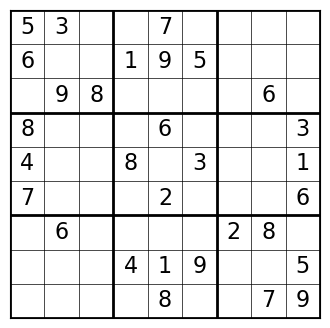

Run:    0 | Loss: 54.26 | Errors: 59 | Best: 59
Run:   74 | Loss:  1.75 | Errors:  0 | Best:  0

✅ Solution found!
------------------------------------------------------
🎉 Success! Puzzle solved in 1.07 seconds.

Final Board (Clues: Black, Solved: Blue, Errors: Red):


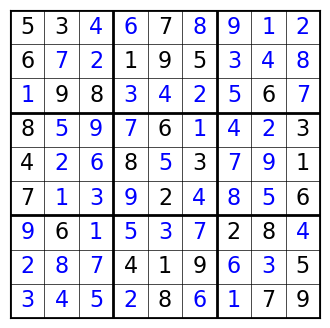

In [15]:
# --- 1. Initialize ---
cfg = Config()
set_global_seed(cfg.seed)
print(f"Using device: {cfg.device}\n")

# --- 2. Select and Prepare Puzzle ---
# Choose from: "easy", "moderate", "paper1", "paper2", "hard", "hardest"
puzzle_name = "moderate"
initial_board = torch.tensor(SUDOKU_PUZZLES[puzzle_name], dtype=torch.int, device=cfg.device)

print(f"Attempting to solve the '{puzzle_name}' puzzle:")
draw_sudoku(initial_board.cpu())

# --- 3. Run Solver ---
start_time = time.time()
solved_board, errors = solve_sudoku(initial_board, cfg)
duration = time.time() - start_time

# --- 4. Display Results ---
print("-" * 54)
if errors == 0:
    print(f"🎉 Success! Puzzle solved in {duration:.2f} seconds.")
else:
    print(f"Solver finished in {duration:.2f} seconds.")
    print(f"The best solution found has {errors} errors.")

print("\nFinal Board (Clues: Black, Solved: Blue, Errors: Red):")
draw_sudoku(initial_board.cpu(), solved_board.cpu())
